In [1]:
from helper_code import *
import numpy as np, os, sys, joblib
import ecg_plot
import pandas as pd
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tsai.all import *
import torch
import optuna
from optuna.integration import FastAIPruningCallback
import transformation_funcs as custom_tfms
torch.cuda.set_device(1) 


def snomedConvert(code,snomed=True):
    codes =  pd.read_csv("data/codes.csv",sep=";")[["Dx","SNOMED CT Code"]]
    if snomed:
        df.columns = [codes[codes["SNOMED CT Code"] == int(x)].iloc[0]["Dx"] for x in df.columns]
        return df

In [2]:
df = pd.read_csv("data/WFDB_CPSC2018.csv")
codes =  pd.read_csv("data/codes.csv",sep=";")
# df.columns = [codes[codes["SNOMED CT Code"] == x].iloc[0]["Dx"] for x in df.columns]
np.sum(codes["SNOMED CT Code"] == int(df.columns[0]))

1

In [3]:
X = np.load('./data/big_numpy_datasets/WFDB_CPSC2018.npy', mmap_mode='c')
df = pd.read_csv("data/WFDB_CPSC2018.csv").drop(columns=["headers","leads"])

y = snomedConvert(df)
y = y[y.columns[0]].to_numpy()
y

array([ True, False, False, ..., False, False, False])

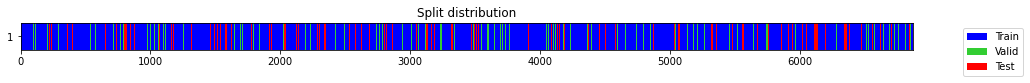

((#5503) [6512,6719,568,3007,5266,2620,287,3001,6680,3730...],
 (#687) [5943,4366,1156,1709,4109,6237,3598,3607,5000,1037...],
 (#687) [2626,5678,5053,2717,3363,963,5856,5471,1253,148...])

In [4]:
splits = get_splits(y, valid_size=.1,test_size=0.1, stratify=True, random_state=23, shuffle=True)
splits

In [5]:
df = pd.read_csv("data/WFDB_CPSC2018.csv").drop(columns=["headers","leads"])
y = snomedConvert(df)
y_multi = []
for i,row in y.iterrows():
    sample_labels = []
    for i,r in enumerate(row):
        if r == True:
            sample_labels.append(y.columns[i])
        
    y_multi.append(list(tuple(sample_labels)))
label_counts = collections.Counter([a for r in y_multi for a in r])
print('Counts by label:', dict(label_counts))

Counts by label: {'right bundle branch block': 1857, 'sinus rhythm': 918, 'atrial fibrillation': 1221, 'ventricular ectopics': 700, 'st depression': 869, 'left bundle branch block': 236, 'st elevation': 220, '1st degree av block': 722, 'premature atrial contraction': 616}


In [ ]:

def save_callback(study, trial):
    if study.best_trial == trial:
        PATH = Path('./models/inception_multilabel_big.pkl')
        PATH.parent.mkdir(parents=True, exist_ok=True)
        global learn
        learn.export(PATH)
def objective(trial:optuna.Trial):    
    # Define search space here. More info here https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html
#     
    tfms = []
    random_shift = trial.suggest_float('rand_shift', 0.0, 0.5, step=.05) 
    noise = trial.suggest_float("noise", 0.0, 1.5, step=.1) 
    window_slice = trial.suggest_float("window_slice", 0.0, 0.6, step=.05) 
    rescale = trial.suggest_float("scale", 0.2, 0.8, step=.1) 
    norm = trial.suggest_categorical('normalize', [0, 1]) 
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True) 
    depth = trial.suggest_int('depth', 8,11,step=1) #
    conv_dropout = trial.suggest_float("conv_dropout", 0.0, 0.05, step=.025) 
    fc_dropout = trial.suggest_float("fc_dropout", 0.0, 0.05, step=.025) 
    nf = trial.suggest_int('num_filters', 16, 32, step=4) 
    
    Xtfms = [TSRandomShift(magnitude=random_shift),TSMagMulNoise(noise),TSWindowSlicing(magnitude=window_slice),custom_tfms.Resample(scale_factor=rescale)]
    if norm!=0:
        Xtfms.append(custom_tfms.Normalize())
    
    batch_tfms = TSStandardize(by_sample=True)
    tfms  = [None, TSMultiLabelClassification()]
    batch_tfms = [TSStandardize(by_sample=True)]
    dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
    metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 

    model = InceptionTimePlus(dls.vars, dls.c, dls.len, conv_dropout=conv_dropout, depth=depth,fc_dropout = fc_dropout,nf = nf)
    global learn
    learn = Learner(dls, model, metrics=metrics,loss_func=nn.BCEWithLogitsLoss(), cbs=FastAIPruningCallback(trial))


#     with ContextManagers([learn.no_logging(), learn.no_bar()]): # [Optional] this prevents fastai from printing anything during training
    learn.fit_one_cycle(100, lr_max=learning_rate)

    # Return the objective value
    return learn.recorder.values[-1][-1] # return the f1 value and try to maximize it

study_name = "inception_study3" # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, storage=storage_name,direction='maximize',load_if_exists=True,
                            pruner=optuna.pruners.PatientPruner(optuna.pruners.MedianPruner(n_warmup_steps=25),patience=20),sampler=optuna.samplers.RandomSampler())

study.optimize(objective, n_trials=100,callbacks=[save_callback])

[I 2022-03-12 14:42:47,422] Using an existing study with name 'inception_study3' instead of creating a new one.


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.585919,0.524662,0.898431,0.611585,0.728057,0.235103,0.988067,0.355176,00:26
1,0.471091,0.413056,0.906680,0.626262,0.859211,0.258215,0.994308,0.397006,00:25
2,0.366726,0.312084,0.914928,0.658547,0.899834,0.322051,0.995044,0.473741,00:25
3,0.293095,0.256646,0.918971,0.676154,0.903944,0.357449,0.994860,0.511479,00:25
4,0.246230,0.224942,0.921074,0.694333,0.870632,0.396744,0.991921,0.544208,00:25
5,0.214679,0.207465,0.923823,0.708808,0.865664,0.426612,0.991004,0.570993,00:25
6,0.190519,0.188553,0.936115,0.768083,0.867555,0.547549,0.988617,0.670701,00:25
7,0.174010,0.176877,0.939673,0.785379,0.868285,0.582873,0.987884,0.696995,00:25
8,0.166965,0.170583,0.938218,0.786314,0.848022,0.586948,0.985680,0.693016,00:26
9,0.160901,0.185133,0.934983,0.787358,0.809392,0.593624,0.981091,0.684476,00:26


In [18]:
InceptionTimePlus?

Init signature:
InceptionTimePlus(
    c_in,
    c_out,
    seq_len=None,
    nf=32,
    nb_filters=None,
    flatten=False,
    concat_pool=False,
    fc_dropout=0.0,
    bn=False,
    y_range=None,
    custom_head=None,
    ks=40,
    bottleneck=True,
    padding='same',
    coord=False,
    separable=False,
    dilation=1,
    stride=1,
    conv_dropout=0.0,
    sa=False,
    se=None,
    norm='Batch',
    zero_norm=False,
    bn_1st=True,
    act=<class 'torch.nn.modules.activation.ReLU'>,
    act_kwargs={},
)
Docstring:     
A sequential container.
Modules will be added to it in the order they are passed in the
constructor. Alternatively, an ``OrderedDict`` of modules can be
passed in. The ``forward()`` method of ``Sequential`` accepts any
input and forwards it to the first module it contains. It then
"chains" outputs to inputs sequentially for each subsequent module,
finally returning the output of the last module.

The value a ``Sequential`` provides over manually calling a sequ

In [ ]:
import transformation_funcs as custom_tfms
tfms  = [[TSRandomShift(magnitude=0.2),TSMagMulNoise(),custom_tfms.TSNormalize(),TSWindowSlicing(magnitude=0.2)], TSMultiLabelClassification()]
batch_tfms = [TSStandardize(by_sample=True)]
dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[32, 128], batch_tfms=batch_tfms, num_workers=0)
metrics =[ precision_multi, recall_multi, specificity_multi, F1_multi] 
model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=13,)
# learn = Learner(dls, model, metrics=metrics, cbs=ShowGraph())
learn.fit_one_cycle(200, lr_max=0.004178080960048705)
learn.recorder.plot_metrics()

In [15]:
from sklearn.metrics import classification_report
tfms  = [None, TSMultiLabelClassification()]
batch_tfms = [TSStandardize(by_sample=True)]
dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=(splits[0],splits[2])) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)

y_pred=np.argmax(valid_preds, axis=1)
y_test=np.argmax(valid_targets, axis=1)

print(classification_report(y_test, y_pred,target_names = df.columns))

                              precision    recall  f1-score   support

   right bundle branch block       0.54      0.92      0.68        79
        ventricular ectopics       0.89      0.94      0.91       127
         atrial fibrillation       1.00      0.81      0.89        21
    left bundle branch block       0.44      0.38      0.41        65
                st elevation       0.90      0.93      0.92       159
         1st degree av block       0.64      0.72      0.67        78
premature atrial contraction       0.82      0.52      0.64        79
                sinus rhythm       0.80      0.36      0.50        22
               st depression       0.91      0.51      0.65        57

                    accuracy                           0.75       687
                   macro avg       0.77      0.68      0.70       687
                weighted avg       0.77      0.75      0.75       687

